In [1]:
pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
# 1. Core Libraries
import numpy as np
import pandas as pd

# 2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# 3. Statistics & Modeling
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf  

# 4. Machine Learning (Scikit-learn)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# 5. XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# 6. Deep Learning (Keras)
from keras import models, layers

In [7]:
 # DATA PROCESSING
    
    
    
# Load the dataset and treat specified values as missing (NaN)
df = pd.read_csv('cpi_fyp.csv', na_values=["NA", "N/A", "None", "null", " "])
    
# Drop irrelevant columns
df = df.drop(columns=['Country Code', 'Indicator Code', 'Status', 'Reference Period'])
    
# Remove rows where 'Indicator Name' contains unwanted keywords
df = df[~df['Indicator Name'].str.contains("Percentage change|Weight|Percent", na=False)] 
    
# Drop rows with missing 'Value' entries
df = df.dropna(subset=['Value'])
    
# Convert categorical columns to optimize memory usage
df['Country Name'] = df['Country Name'].astype('category')  
df['Indicator Name'] = df['Indicator Name'].astype('category')
    
# Format 'Time Period' for time-series analysis
df['Time Period'] = df['Time Period'].astype(str).apply(lambda x: x + 'M1' if 'M' not in x else x)
df['Time Period'] = pd.to_datetime(df['Time Period'].str.replace('M', '-'), format='%Y-%m')
    
# Display dataset info
df.info()
df.head

<class 'pandas.core.frame.DataFrame'>
Index: 23903 entries, 12 to 150324
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country Name    23903 non-null  category      
 1   Indicator Name  23903 non-null  category      
 2   Time Period     23903 non-null  datetime64[ns]
 3   Value           23903 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 607.9 KB


<bound method NDFrame.head of              Country Name                                     Indicator Name  \
12              Indonesia                    Consumer Price Index, All items   
13              Indonesia                    Consumer Price Index, All items   
14              Indonesia                    Consumer Price Index, All items   
15              Indonesia                    Consumer Price Index, All items   
16              Indonesia                    Consumer Price Index, All items   
...                   ...                                                ...   
150318           Malaysia  Furnishings, household equipment and routine h...   
150319           Malaysia  Furnishings, household equipment and routine h...   
150320           Malaysia  Furnishings, household equipment and routine h...   
150323  Brunei Darussalam                                      Communication   
150324          Singapore                    Consumer Price Index, All items   

       Ti

In [9]:
# PIVOTING DATA



# Ensure 'Country Name' is explicitly included in the dataset (avoiding issues with indexing)
df = df[['Time Period', 'Country Name', 'Indicator Name', 'Value']]
    
# Pivot the dataset so that each unique 'Indicator Name' becomes a separate column
# This reshapes the data to have one row per 'Time Period' and 'Country Name', with CPI categories as columns
df_col = df.pivot_table(index=["Time Period", "Country Name"], 
                              columns="Indicator Name", 
                              values="Value", 
                              aggfunc="mean")  # Aggregating by mean in case of duplicates
    
# Drop rows with missing values to ensure a complete dataset
df_col.dropna(inplace=True)
    
# Reset index to make 'Country Name' and 'Time Period' regular columns instead of index levels
df_col.reset_index(inplace=True)
    
# Display dataset information and the first few rows for verification
print(df_col.info())
df_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 15 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   Time Period                                                         852 non-null    datetime64[ns]
 1   Country Name                                                        852 non-null    category      
 2   Alcoholic Beverages, Tobacco, and Narcotics                         852 non-null    float64       
 3   Clothing and footwear                                               852 non-null    float64       
 4   Communication                                                       852 non-null    float64       
 5   Consumer Price Index, All items                                     852 non-null    float64       
 6   Education                                                 

/var/folders/km/kqnqtg953b76gw0hctk94d1m0000gn/T/ipykernel_13730/239127615.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_col = df.pivot_table(index=["Time Period", "Country Name"],


Indicator Name Time Period Country Name  \
0               2001-01-01     Cambodia   
1               2001-02-01     Cambodia   
2               2001-03-01     Cambodia   
3               2001-04-01     Cambodia   
4               2001-05-01     Cambodia   

Indicator Name  Alcoholic Beverages, Tobacco, and Narcotics  \
0                                                    98.043   
1                                                    97.875   
2                                                    98.244   
3                                                    97.568   
4                                                    97.627   

Indicator Name  Clothing and footwear  Communication  \
0                          102.148417     100.877125   
1                          105.098000     100.434000   
2                          105.092000     100.434000   
3                          103.305000     100.434000   
4                           97.816000     100.434000   

Indicator Name  Consumer Price Index, All items   Education  \
0                                     82.291792  103.326625   
1                                     82.944000  101.053000   
2                                     83.990000  101.053000   
3                                     81.787000  101.053000   
4                                     81.996000  101.053000   

Indicator Name  Food and non-alcoholic beverages  \
0                                       73.58275   
1                                       73.33100   
2                                       75.50300   
3                                       71.96500   
4                                       71.36600   

Indicator Name  Furnishings, household equipment and routine household maintenance  \
0                                                       96.722375                    
1                                                       97.911000                    
2                                                       98.321000                    
3                                                       97.532000                    
4                                                       98.982000                    

Indicator Name   Health  Housing, Water, Electricity, Gas and Other Fuels  \
0               99.5375                                            80.498   
1               97.6860                                            84.483   
2               97.6860                                            84.653   
3               98.8400                                            84.645   
4               99.0740                                            85.258   

Indicator Name  Miscellaneous goods and services  Recreation and culture  \
0                                         90.780                104.0595   
1                                         85.315                106.5750   
2                                         85.566                106.5750   
3                                         84.689                106.5750   
4                                         93.835                108.7530   

Indicator Name  Restaurants and hotels  Transport  
0                           106.974833  77.439833  
1                           108.857000  77.749000  
2                           108.795000  77.863000  
3                            99.044000  77.993000  
4                           101.290000  78.730000

/var/folders/km/kqnqtg953b76gw0hctk94d1m0000gn/T/ipykernel_13730/3048589443.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


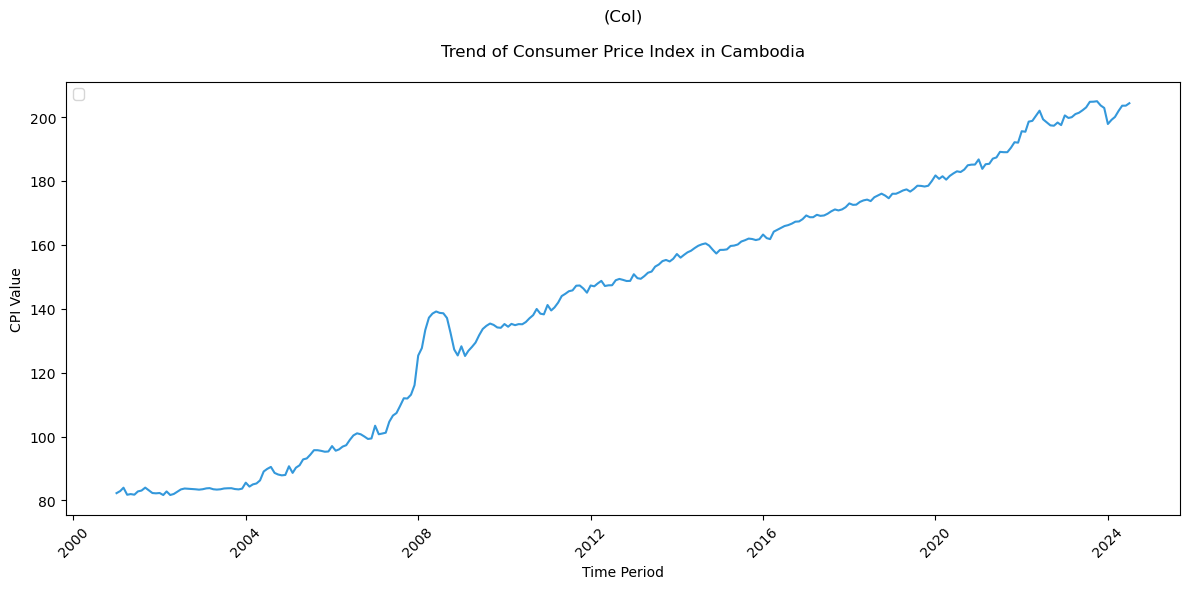

In [11]:
# PLOTTING CPI TREND FOR Cambodia



# Filter the dataset to include only Malaysia's data
df_cambodia = df_col[df_col["Country Name"] == "Cambodia"]
    
# Select only the 'Time Period' and 'Consumer Price Index, All items' columns
df_cambodia = df_cambodia[['Time Period', 'Consumer Price Index, All items']]
    
plt.figure(figsize=(12, 6))  # Set figure size for better readability
plt.plot(df_cambodia['Time Period'], df_cambodia['Consumer Price Index, All items'], 
             color='#3498DB')
plt.title("(Col)\n\nTrend of Consumer Price Index in Cambodia\n")
plt.xlabel("Time Period")
plt.ylabel("CPI Value")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
    
# Display the plot
plt.show()

In [13]:
# SVR Cambodia 



# Assuming df_pivot is your pivoted DataFrame containing all columns
# Filter data for Malaysia only
df_cambodia = df_col[df_col["Country Name"] == "Cambodia"]
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_cambodia = df_cambodia.drop(['Country Name', 'Time Period'], axis=1)

In [15]:
# Use the 'Consumer Price Index, All items' as the target variable
target_column = 'Consumer Price Index, All items'
    
# Extract the features (other indicator columns) and target variable
X = df_cambodia.drop(target_column, axis=1)  # Features: all other indicators
y = df_cambodia[target_column]  # Target: 'Consumer Price Index, All items'
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Standardize the features (SVR is sensitive to feature scaling)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
# Reshape y_train and y_test to 2D arrays for scaling
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
    
# Scale features and target
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [19]:
# Define parameter grid
param_grid = {
        'kernel': ['rbf', 'poly', 'sigmoid'],  
        'C': [1, 10, 100, 1000],  
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
        'epsilon': [0.01, 0.1, 0.2]
    }
    
# Initialize GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train_scaled.ravel())
    
# Extract best parameters and score
best_params = grid_search.best_params_
    
# Best model parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ........C=1, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .......C=1, epsilon=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=1, epsilon=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=1, epsilon=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=1, epsilon=0.1, gamma=

In [21]:
# Initialize the SVR model
svr = SVR(kernel='rbf', C=1000, gamma=0.01, epsilon=0.01)
    
# Train the model
svr.fit(X_train_scaled, y_train_scaled.ravel())
    
# Make predictions on the test set
y_pred_scaled = svr.predict(X_test_scaled)
    
# Inverse transform the predicted and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_scaled)

In [23]:
# Calculate MAE, MSE, RMSE, and R²
mae_cambodia = mean_absolute_error(y_test_original, y_pred)  # Mean Absolute Error
mse_cambodia = mean_squared_error(y_test_original, y_pred)  # Mean Squared Error
rmse_cambodia = np.sqrt(mse_cambodia)  # Root Mean Squared Error
r2_cambodia = r2_score(y_test_original, y_pred)  # R² (Coefficient of Determination)
    
# Print the results
print(f"Mean Absolute Error (MAE): {mae_cambodia}")
print(f"Mean Squared Error (MSE): {mse_cambodia}")
print(f"Root Mean Squared Error (RMSE): {rmse_cambodia}")
print(f"R² Score: {r2_cambodia}")

Mean Absolute Error (MAE): 0.22280059617530187
Mean Squared Error (MSE): 0.06753429336126993
Root Mean Squared Error (RMSE): 0.25987361035947826
R² Score: 0.9999578241612725


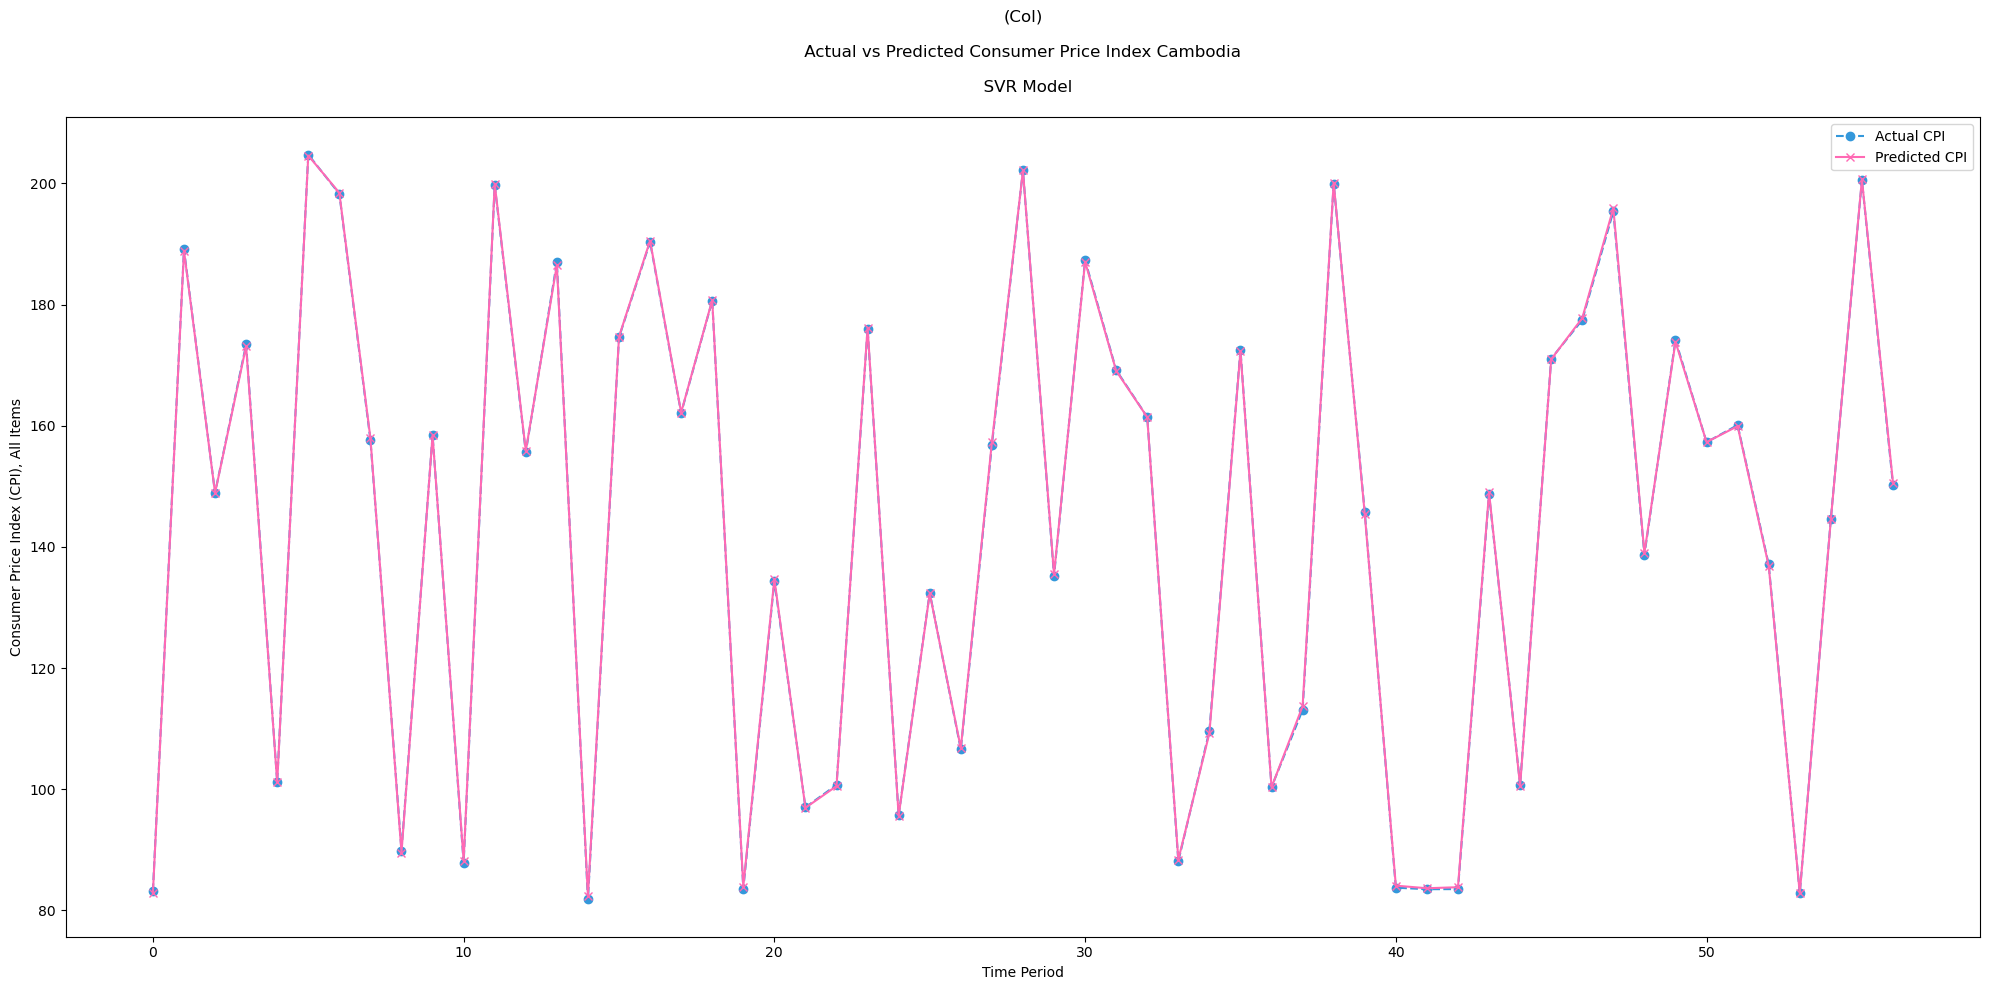

In [25]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test_original, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All Items")
plt.title("(Col)\n\n Actual vs Predicted Consumer Price Index Cambodia \n\n  SVR Model\n ")
plt.tight_layout()
plt.show()

/var/folders/km/kqnqtg953b76gw0hctk94d1m0000gn/T/ipykernel_13730/1167101431.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


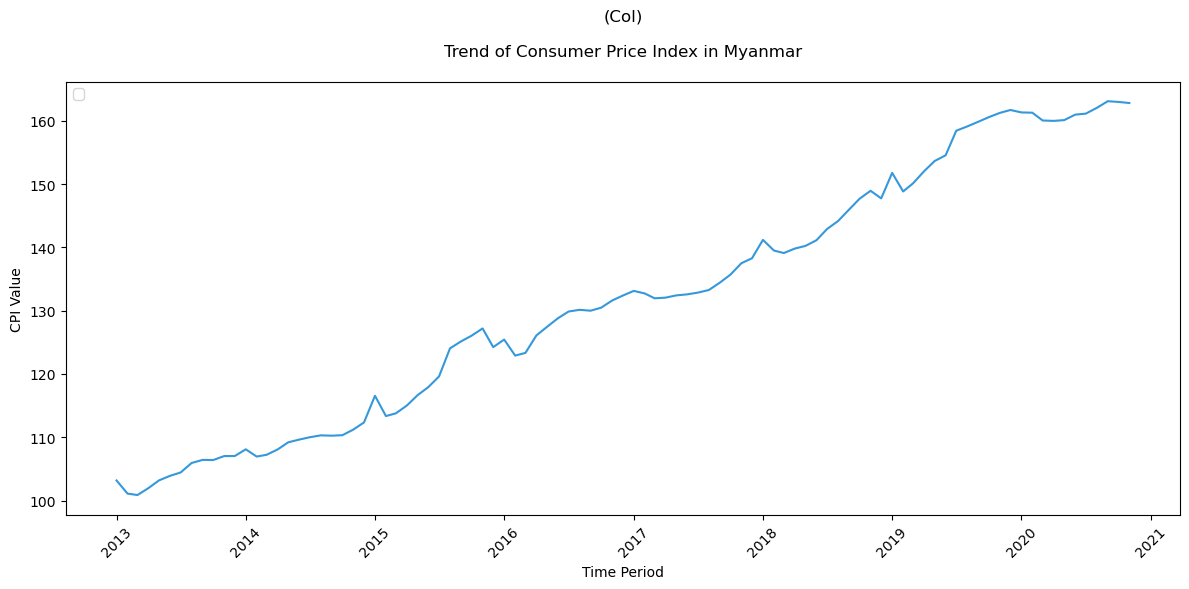

In [27]:
# PLOTTING CPI TREND FOR Myanmar



# Filter the dataset to include only Malaysia's data
df_myanmar = df_col[df_col["Country Name"] == "Myanmar"]
    
# Select only the 'Time Period' and 'Consumer Price Index, All items' columns
df_myanmar = df_myanmar[['Time Period', 'Consumer Price Index, All items']]
    
plt.figure(figsize=(12, 6))  # Set figure size for better readability
plt.plot(df_myanmar['Time Period'], df_myanmar['Consumer Price Index, All items'], 
             color='#3498DB')
plt.title("(Col)\n\nTrend of Consumer Price Index in Myanmar\n")
plt.xlabel("Time Period")
plt.ylabel("CPI Value")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
    
# Display the plot
plt.show()

In [29]:
# SVR Myanmar



# Assuming df_pivot is your pivoted DataFrame containing all columns
# Filter data for Malaysia only
df_myanmar = df_col[df_col["Country Name"] == "Myanmar"]
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_myanmar = df_myanmar.drop(['Country Name', 'Time Period'], axis=1)  

In [31]:
# Use the 'Consumer Price Index, All items' as the target variable
target_column = 'Consumer Price Index, All items'
    
# Extract the features (other indicator columns) and target variable
X = df_myanmar.drop(target_column, axis=1)  # Features: all other indicators
y = df_myanmar[target_column]  # Target: 'Consumer Price Index, All items'
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Standardize the features (SVR is sensitive to feature scaling)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
# Reshape y_train and y_test to 2D arrays for scaling
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
    
# Scale features and target
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [35]:
# Define parameter grid
param_grid = {
        'kernel': ['rbf', 'poly', 'sigmoid'],  
        'C': [1, 10, 100, 1000],  
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
        'epsilon': [0.01, 0.1, 0.2]
    }
    
# Initialize GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    
# Fit the model
grid_search.fit(X_train_scaled, y_train_scaled.ravel())
    
# Extract best parameters and score
best_params = grid_search.best_params_
    
# Best model parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'C': 1000, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [37]:
# Initialize the SVR model
svr = SVR(kernel='rbf', C=1000, gamma=0.01, epsilon=0.01)
    
# Train the model
svr.fit(X_train_scaled, y_train_scaled.ravel())
    
# Make predictions on the test set
y_pred_scaled = svr.predict(X_test_scaled)
    
# Inverse transform the predicted and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_scaled)

In [39]:
# Calculate MAE, MSE, RMSE, and R²
mae_myan = mean_absolute_error(y_test_original, y_pred)  # Mean Absolute Error
mse_myan = mean_squared_error(y_test_original, y_pred)  # Mean Squared Error
rmse_myan = np.sqrt(mse_myan)  # Root Mean Squared Error
r2_myan = r2_score(y_test_original, y_pred)  # R² (Coefficient of Determination)
    
# Print the results
print(f"Mean Absolute Error (MAE): {mae_myan}")
print(f"Mean Squared Error (MSE): {mse_myan}")
print(f"Root Mean Squared Error (RMSE): {rmse_myan}")
print(f"R² Score: {r2_myan}")

Mean Absolute Error (MAE): 0.12086841213098416
Mean Squared Error (MSE): 0.024861625729707876
Root Mean Squared Error (RMSE): 0.1576756979680378
R² Score: 0.9999279370953122


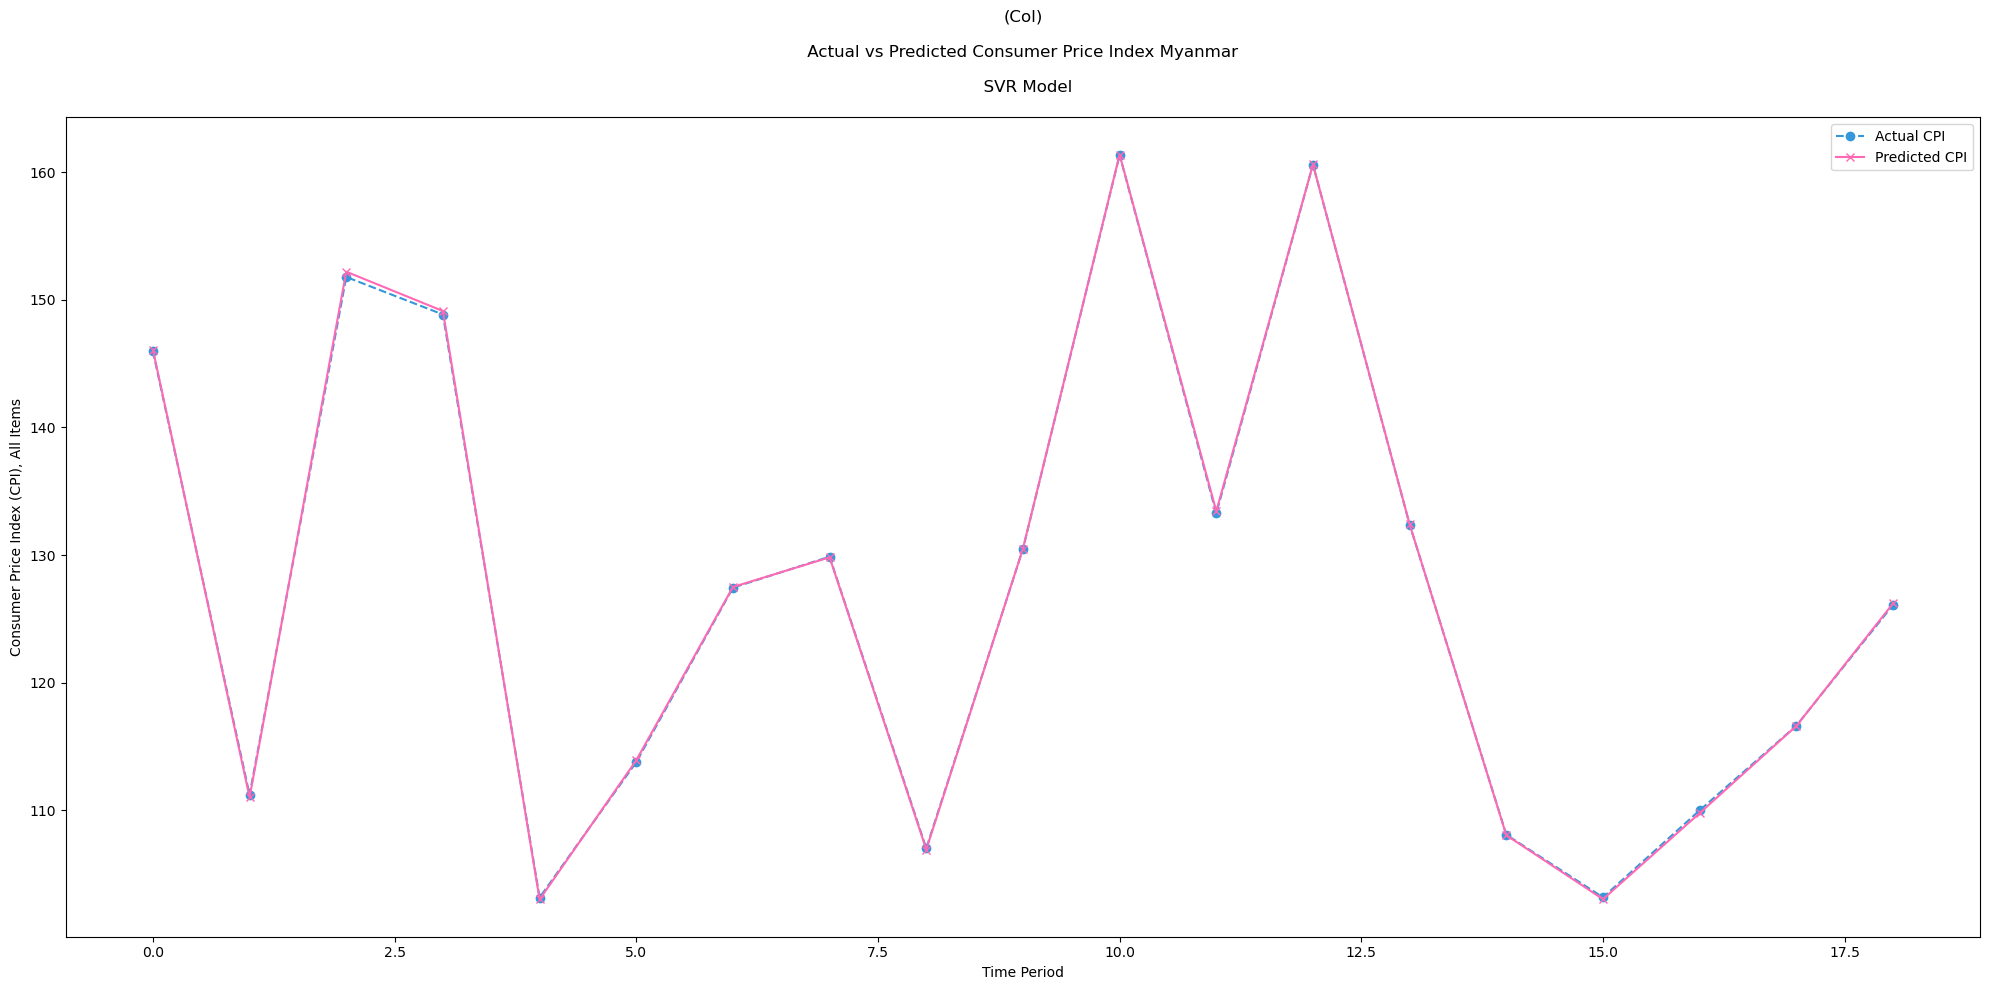

In [41]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test_original, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All Items")
    
# Modify the title to break onto the next line
plt.title("(Col)\n\n Actual vs Predicted Consumer Price Index Myanmar \n\n  SVR Model\n ")
plt.tight_layout()
plt.show()

/var/folders/km/kqnqtg953b76gw0hctk94d1m0000gn/T/ipykernel_13730/3930009454.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


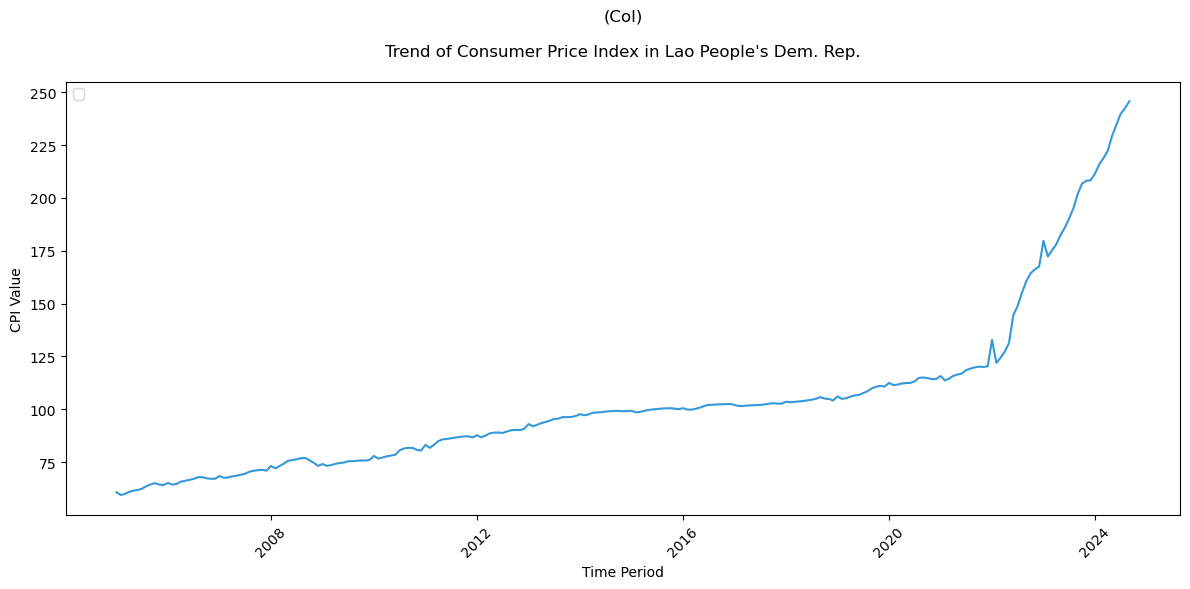

In [43]:
# PLOTTING CPI TREND FOR lao



# Filter the dataset to include only Malaysia's data
df_lao = df_col[df_col["Country Name"] == "Lao People's Dem. Rep."]
    
# Select only the 'Time Period' and 'Consumer Price Index, All items' columns
df_lao = df_lao[['Time Period', 'Consumer Price Index, All items']]
    
plt.figure(figsize=(12, 6))  # Set figure size for better readability
plt.plot(df_lao['Time Period'], df_lao['Consumer Price Index, All items'], 
             color='#3498DB')
plt.title("(Col)\n\nTrend of Consumer Price Index in Lao People's Dem. Rep.\n")
plt.xlabel("Time Period")
plt.ylabel("CPI Value")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
    
# Display the plot
plt.show()

In [47]:
# SVR Lao



# Assuming df_pivot is your pivoted DataFrame containing all columns
# Filter data for Malaysia only
df_lao = df_col[df_col["Country Name"] == "Lao People's Dem. Rep."]
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_lao = df_lao.drop(['Country Name', 'Time Period'], axis=1)

In [49]:
# Use the 'Consumer Price Index, All items' as the target variable
target_column = 'Consumer Price Index, All items'
    
# Extract the features (other indicator columns) and target variable
X = df_lao.drop(target_column, axis=1)  # Features: all other indicators
y = df_lao[target_column]  # Target: 'Consumer Price Index, All items'
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Standardize the features (SVR is sensitive to feature scaling)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
# Reshape y_train and y_test to 2D arrays for scaling
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
    
# Scale features and target
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [53]:
# Define parameter grid
param_grid = {
        'kernel': ['rbf', 'poly', 'sigmoid'],  
        'C': [1, 10, 100, 1000],  
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
        'epsilon': [0.01, 0.1, 0.2]
    }
    
# Initialize GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    
# Fit the model
grid_search.fit(X_train_scaled, y_train_scaled.ravel())
    
# Extract best parameters and score
best_params = grid_search.best_params_
    
# Best model parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ........C=1, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=scal

In [55]:
# Initialize the SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.01)
    
# Train the model
svr.fit(X_train_scaled, y_train_scaled.ravel())
    
# Make predictions on the test set
y_pred_scaled = svr.predict(X_test_scaled)
    
# Inverse transform the predicted and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_scaled)

In [57]:
# Calculate MAE, MSE, RMSE, and R²
mae_lao = mean_absolute_error(y_test_original, y_pred)  # Mean Absolute Error
mse_lao = mean_squared_error(y_test_original, y_pred)  # Mean Squared Error
rmse_lao = np.sqrt(mse_lao)  # Root Mean Squared Error
r2_lao = r2_score(y_test_original, y_pred)  # R² (Coefficient of Determination)
    
# Print the results
print(f"Mean Absolute Error (MAE): {mae_lao}")
print(f"Mean Squared Error (MSE): {mse_lao}")
print(f"Root Mean Squared Error (RMSE): {rmse_lao}")
print(f"R² Score: {r2_lao}")

Mean Absolute Error (MAE): 0.1882755714017675
Mean Squared Error (MSE): 0.04532154122347137
Root Mean Squared Error (RMSE): 0.21288856527176694
R² Score: 0.9999727259888683


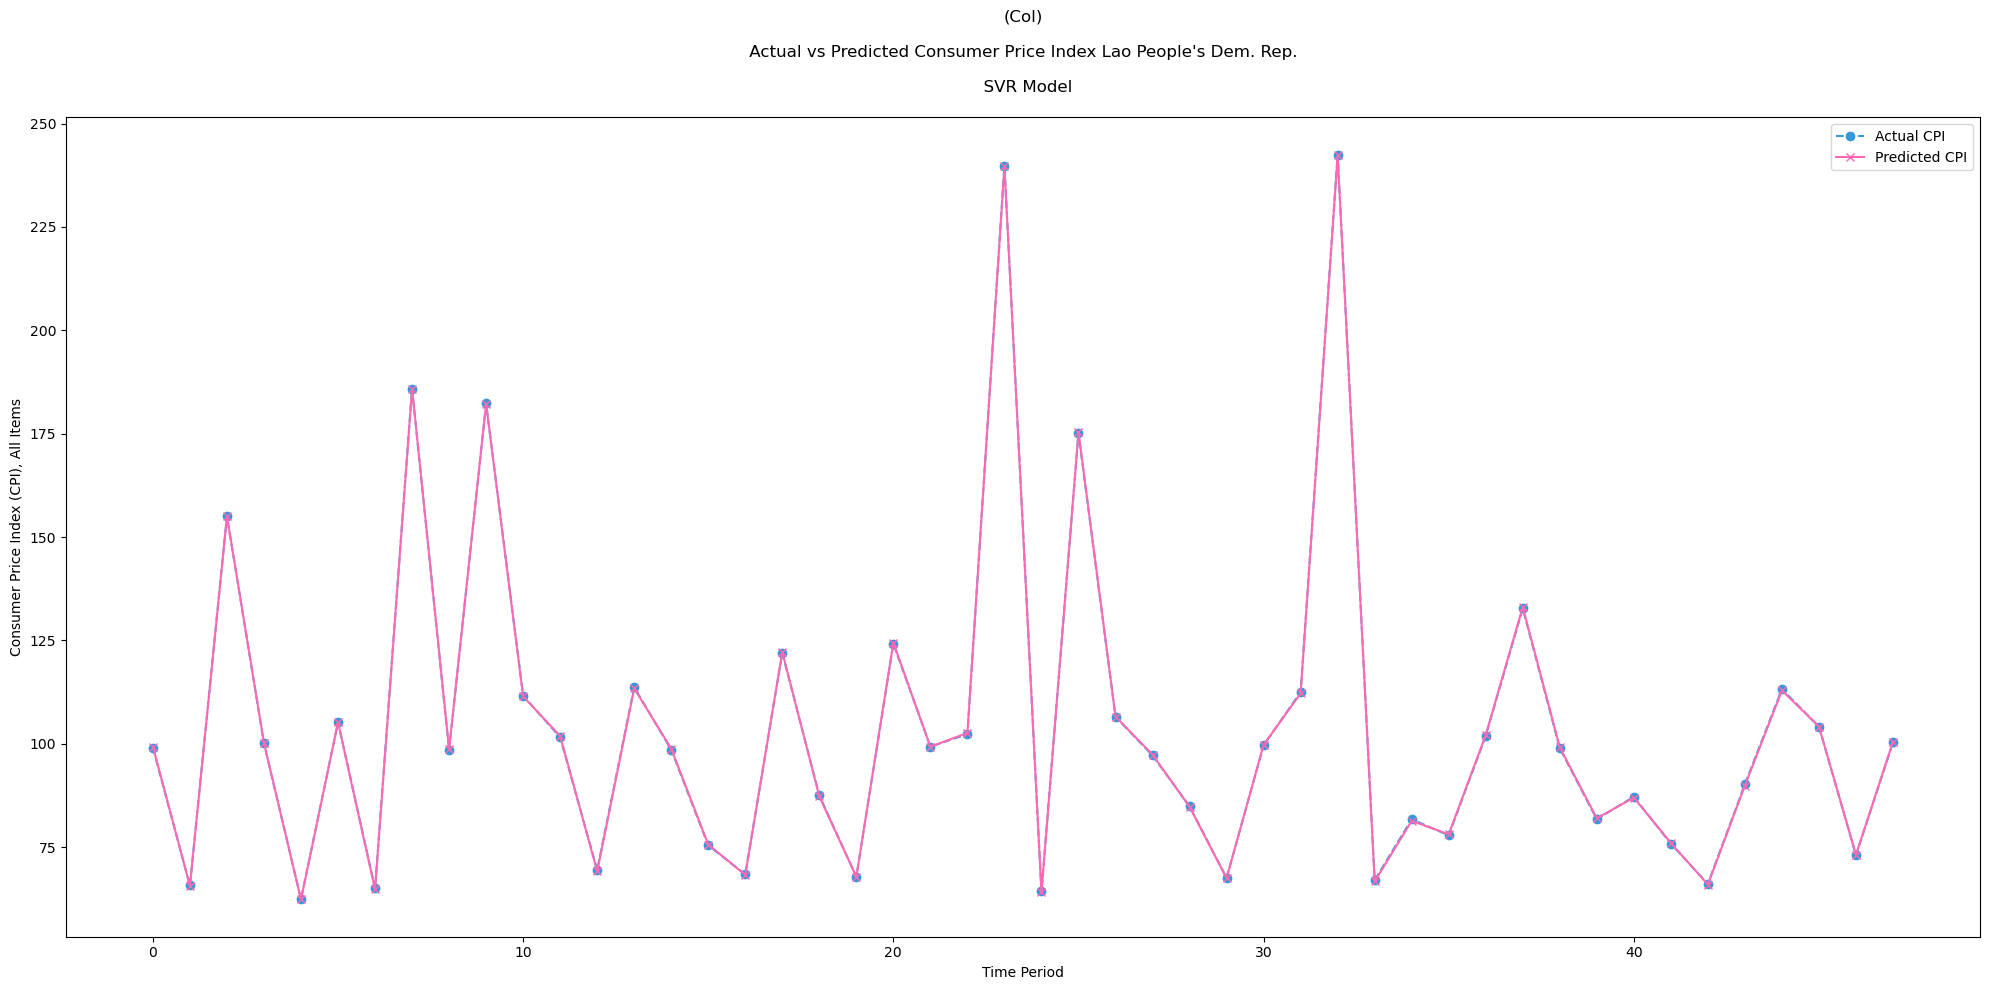

In [59]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test_original, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All Items")
    
# Modify the title to break onto the next line
plt.title("(Col)\n\n Actual vs Predicted Consumer Price Index Lao People's Dem. Rep. \n\n  SVR Model\n ")
plt.tight_layout()
plt.show()

/var/folders/km/kqnqtg953b76gw0hctk94d1m0000gn/T/ipykernel_13730/2433442117.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


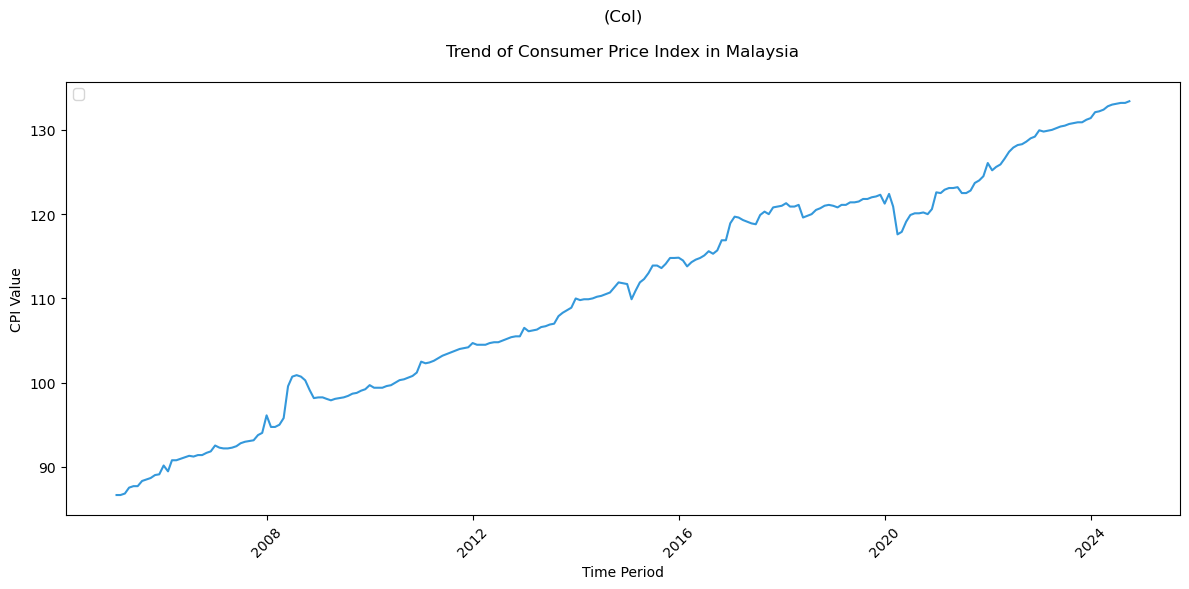

In [61]:
# PLOTTING CPI TREND FOR MSIA



# Filter the dataset to include only Malaysia's data
df_msia = df_col[df_col["Country Name"] == "Malaysia"]
    
# Select only the 'Time Period' and 'Consumer Price Index, All items' columns
df_msia = df_msia[['Time Period', 'Consumer Price Index, All items']]
    
plt.figure(figsize=(12, 6))  # Set figure size for better readability
plt.plot(df_msia['Time Period'], df_msia['Consumer Price Index, All items'], 
             color='#3498DB')
plt.title("(Col)\n\nTrend of Consumer Price Index in Malaysia\n")
plt.xlabel("Time Period")
plt.ylabel("CPI Value")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
    
# Display the plot
plt.show()

In [65]:
# SVR Malaysia



# Assuming df_pivot is your pivoted DataFrame containing all columns
# Filter data for Malaysia only
df_msia = df_col[df_col["Country Name"] == "Malaysia"]
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_msia = df_msia.drop(['Country Name', 'Time Period'], axis=1)

In [67]:
# Use the 'Consumer Price Index, All items' as the target variable
target_column = 'Consumer Price Index, All items'
    
# Extract the features (other indicator columns) and target variable
X = df_msia.drop(target_column, axis=1)  # Features: all other indicators
y = df_msia[target_column]  # Target: 'Consumer Price Index, All items'
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Standardize the features (SVR is sensitive to feature scaling)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
# Reshape y_train and y_test to 2D arrays for scaling
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
    
# Scale features and target
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [71]:
# Initialize the SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.01)
    
# Train the model
svr.fit(X_train_scaled, y_train_scaled.ravel())
    
# Make predictions on the test set
y_pred_scaled = svr.predict(X_test_scaled)
    
# Inverse transform the predicted and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_scaled)

In [73]:
# Calculate MAE, MSE, RMSE, and R²
mae_svr = mean_absolute_error(y_test_original, y_pred)  # Mean Absolute Error
mse_svr = mean_squared_error(y_test_original, y_pred)  # Mean Squared Error
rmse_svr = np.sqrt(mse_svr)  # Root Mean Squared Error
r2_svr = r2_score(y_test_original, y_pred)  # R² (Coefficient of Determination)
    
# Print the results
print(f"Mean Absolute Error (MAE): {mae_svr}")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"R² Score: {r2_svr}")

Mean Absolute Error (MAE): 0.0583546496508669
Mean Squared Error (MSE): 0.005041177718180956
Root Mean Squared Error (RMSE): 0.07100125152545521
R² Score: 0.9999728339022117


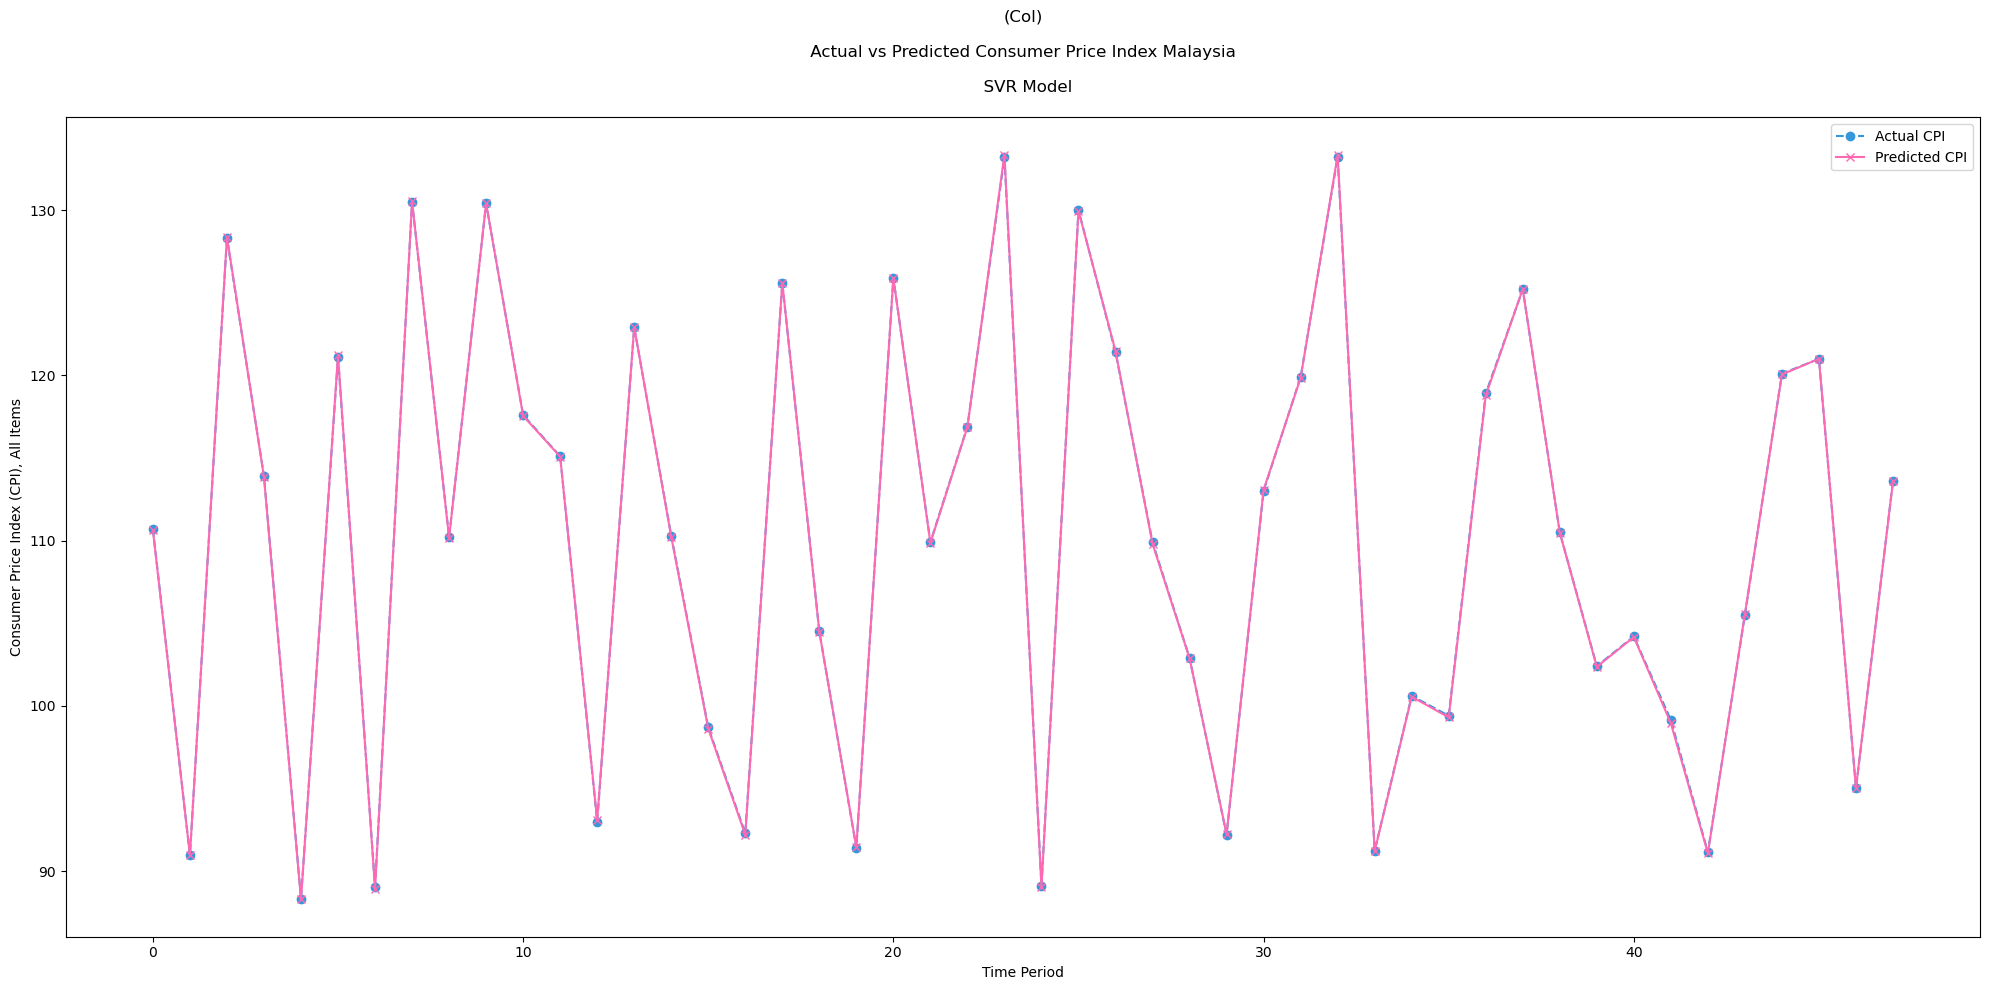

In [75]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test_original, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All Items")
plt.title("(Col)\n\n Actual vs Predicted Consumer Price Index Malaysia \n\n  SVR Model\n ")
plt.tight_layout()
plt.show()

In [77]:
# Define the error metrics for each model
metrics = {
        "Country": ["Malaysia", "Cambodia", "Myanmar", "Lao People's Dem. Rep."],
        "MAE": [mae_svr, mae_cambodia, mae_myan, mae_lao],
        "MSE": [mse_svr, mse_cambodia, mse_myan, mse_lao],
        "RMSE": [rmse_svr, rmse_cambodia, rmse_myan, rmse_lao],
        "R² Score": [r2_svr, r2_cambodia, r2_myan, r2_lao]
    }
    
# Create a DataFrame to compare the models
comparison_df = pd.DataFrame(metrics)
    
# Display the comparison table
print(comparison_df)

                  Country       MAE       MSE      RMSE  R² Score
0                Malaysia  0.058355  0.005041  0.071001  0.999973
1                Cambodia  0.222801  0.067534  0.259874  0.999958
2                 Myanmar  0.120868  0.024862  0.157676  0.999928
3  Lao People's Dem. Rep.  0.188276  0.045322  0.212889  0.999973
